In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100
image_size=[256,256]

In [3]:
xce = Xception(input_shape = image_size + [3], weights = 'imagenet', include_top =  False)

83689472/83683744 [==============================] - 16s 0us/step


In [4]:
for layer in xce.layers:
    layer.trainable = False

In [5]:
xce.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
    
)

Found 14303 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
len(dataset)

447

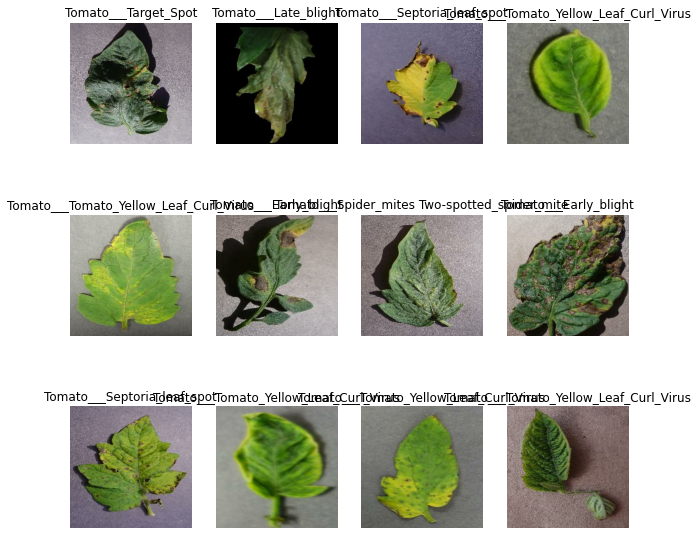

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1,test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split *ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    xce,
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
    
])
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (32, 131072)              0         
_________________________________________________________________
dense (Dense)                (32, 64)                  8388672   
_________________________________________________________________
dense_1 (Dense)              (32, 10)                  650       
Total params: 29,250,802
Trainable params: 8,389,322
Non-trainable params: 20,861,480
__________________________________

In [18]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
357/357 [==============================] - 43s 89ms/step - loss: 1.8529 - accuracy: 0.5220 - val_loss: 1.2342 - val_accuracy: 0.6442
Epoch 2/100
357/357 [==============================] - 26s 72ms/step - loss: 1.1215 - accuracy: 0.6563 - val_loss: 1.0241 - val_accuracy: 0.6875
Epoch 3/100
357/357 [==============================] - 26s 72ms/step - loss: 0.9111 - accuracy: 0.7166 - val_loss: 0.7860 - val_accuracy: 0.7415
Epoch 4/100
357/357 [==============================] - 26s 72ms/step - loss: 0.7606 - accuracy: 0.7536 - val_loss: 0.7286 - val_accuracy: 0.7741711  - ETA: 5s - loss: 0.7734 - accura - ETA
Epoch 5/100
357/357 [==============================] - 25s 71ms/step - loss: 0.6499 - accuracy: 0.7844 - val_loss: 0.7403 - val_accuracy: 0.7614
Epoch 6/100
357/357 [==============================] - 26s 72ms/step - loss: 0.5569 - accuracy: 0.8151 - val_loss: 0.5722 - val_accuracy: 0.8097
Epoch 7/100
357/357 [==============================] - 25s 71ms/step - loss: 0.5046 - 

357/357 [==============================] - 26s 74ms/step - loss: 0.2506 - accuracy: 0.9166 - val_loss: 0.3212 - val_accuracy: 0.8935
Epoch 55/100
357/357 [==============================] - 26s 71ms/step - loss: 0.2434 - accuracy: 0.9144 - val_loss: 0.2909 - val_accuracy: 0.9006
Epoch 56/100
357/357 [==============================] - 25s 71ms/step - loss: 0.2364 - accuracy: 0.9188 - val_loss: 0.3405 - val_accuracy: 0.8885
Epoch 57/100
357/357 [==============================] - 26s 71ms/step - loss: 0.2398 - accuracy: 0.9151 - val_loss: 0.3134 - val_accuracy: 0.8977
Epoch 58/100
357/357 [==============================] - 26s 72ms/step - loss: 0.2381 - accuracy: 0.9207 - val_loss: 0.3146 - val_accuracy: 0.8963
Epoch 59/100
357/357 [==============================] - 25s 71ms/step - loss: 0.2411 - accuracy: 0.9181 - val_loss: 0.3199 - val_accuracy: 0.8956
Epoch 60/100
357/357 [==============================] - 25s 71ms/step - loss: 0.2225 - accuracy: 0.9252 - val_loss: 0.3345 - val_accuracy

357/357 [==============================] - 26s 72ms/step - loss: 0.1834 - accuracy: 0.9377 - val_loss: 0.2811 - val_accuracy: 0.90915s - loss: 0.1720 -  - ETA: 14s - - ETA: 4s - - ETA: 3s - loss: 0.1759 - accuracy:  - ETA: 2s - - ETA: 0s - loss: 0.1803 - 
Epoch 96/100
357/357 [==============================] - 26s 72ms/step - loss: 0.2056 - accuracy: 0.9320 - val_loss: 0.2832 - val_accuracy: 0.9041 loss: 0.2042 - accuracy - ETA
Epoch 97/100
357/357 [==============================] - 26s 72ms/step - loss: 0.1972 - accuracy: 0.9320 - val_loss: 0.2757 - val_accuracy: 0.9134
Epoch 98/100
357/357 [==============================] - 27s 75ms/step - loss: 0.2074 - accuracy: 0.9313 - val_loss: 0.3503 - val_accuracy: 0.9006
Epoch 99/100
357/357 [==============================] - 29s 82ms/step - loss: 0.2000 - accuracy: 0.9315 - val_loss: 0.2633 - val_accuracy: 0.9091
Epoch 100/100
357/357 [==============================] - 28s 79ms/step - loss: 0.2111 - accuracy: 0.9307 - val_loss: 0.2490 - val_

In [20]:
scores = model.evaluate(test_ds)

46/46 [==============================] - 8s 63ms/step - loss: 0.2469 - accuracy: 0.9226 0s - loss: 0.2414 - ac - ETA: 0s - loss: 0.2415 - accuracy


In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 357}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
history.history['accuracy']

[0.5220170021057129,
 0.6563074588775635,
 0.71662437915802,
 0.7535673379898071,
 0.7843824028968811,
 0.8151098489761353,
 0.8317430019378662,
 0.8412851095199585,
 0.8495141267776489,
 0.8425982594490051,
 0.85441654920578,
 0.8634334206581116,
 0.8636084794998169,
 0.8728880286216736,
 0.8737634420394897,
 0.876389741897583,
 0.8773527145385742,
 0.885844349861145,
 0.8757769465446472,
 0.8832180500030518,
 0.8814672231674194,
 0.8909218311309814,
 0.8966996669769287,
 0.8863695859909058,
 0.8981878757476807,
 0.8958241939544678,
 0.8947737216949463,
 0.8974875211715698,
 0.8949487805366516,
 0.8981878757476807,
 0.9001138210296631,
 0.895298957824707,
 0.9056289792060852,
 0.9054539203643799,
 0.9036155343055725,
 0.9053663611412048,
 0.9077300429344177,
 0.9051037430763245,
 0.9082552790641785,
 0.9059791564941406,
 0.9132452011108398,
 0.9116694331169128,
 0.9083428382873535,
 0.9194607138633728,
 0.9057165384292603,
 0.9176223278045654,
 0.9107064604759216,
 0.9155213236808777,

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

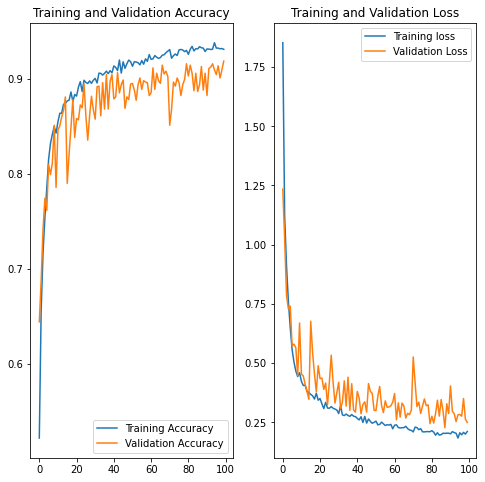

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label= 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first_image to predict
actual label: Tomato___healthy
tf.Tensor(9, shape=(), dtype=int32)
predicted label: Tomato___healthy


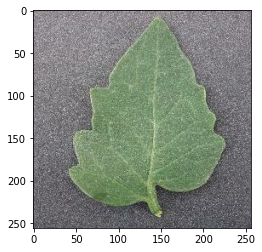

In [27]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first_image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print(labels_batch[0])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

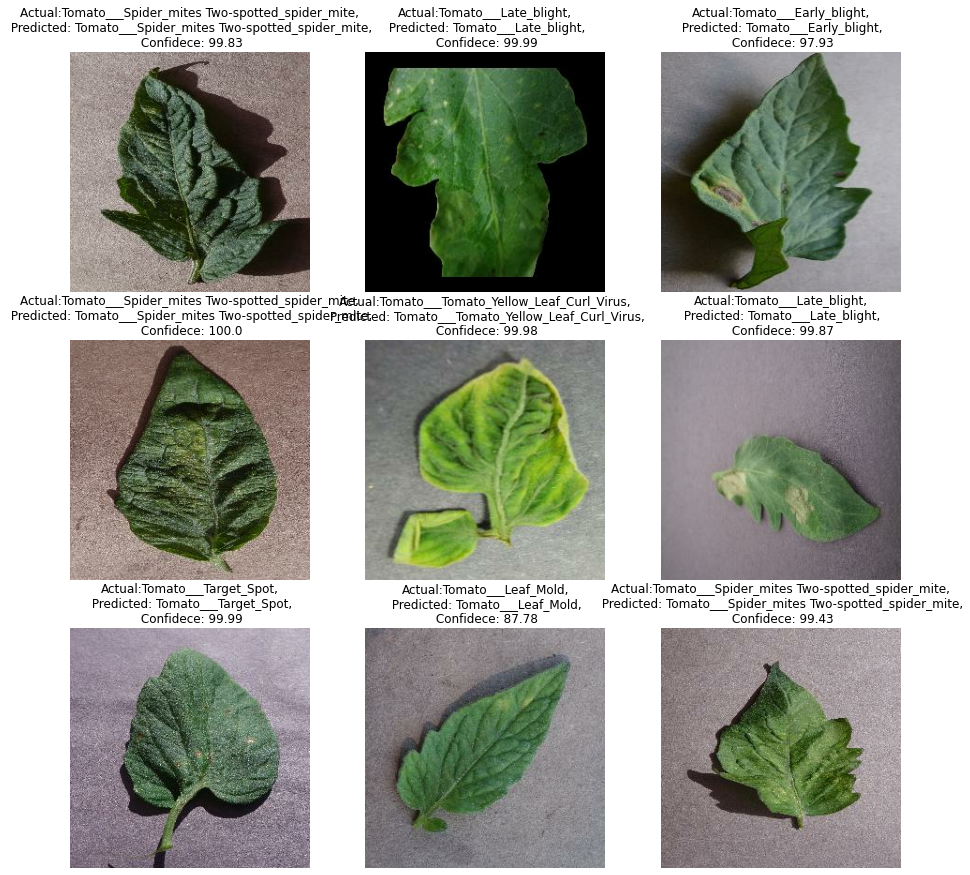

In [29]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidece: {confidence}")
        
        plt.axis("off")

In [38]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('Models/xce_100.h5')

C:\Users\Khwopa\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
#model = models.load_model('Models/xce_1.h5')

In [32]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [33]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools
cm=confusion_matrix(predicted_labels, correct_labels)
cm

array([[199,   0,   1,   0,   1,   0,   1,   0,   0,   0],
       [  5,  93,   1,   5,   3,   1,   0,   0,   0,   0],
       [  5,   6, 201,   1,   2,   1,   1,   1,   0,   0],
       [  0,   2,   1,  78,   0,   0,   0,   1,   5,   0],
       [  0,   1,   1,   6, 158,   0,   0,   0,   3,   0],
       [  0,   0,   0,   9,   2, 157,   7,   0,   5,   0],
       [  4,   5,   0,   0,   2,  10, 123,   0,   0,   3],
       [  5,   0,   0,   0,   0,   0,   1, 159,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  29,   0],
       [  0,   0,   0,   0,   3,   0,   2,   0,   0, 161]], dtype=int64)

In [34]:
target_names = []
for key in dataset.class_names:
    target_names.append(key)

In [35]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


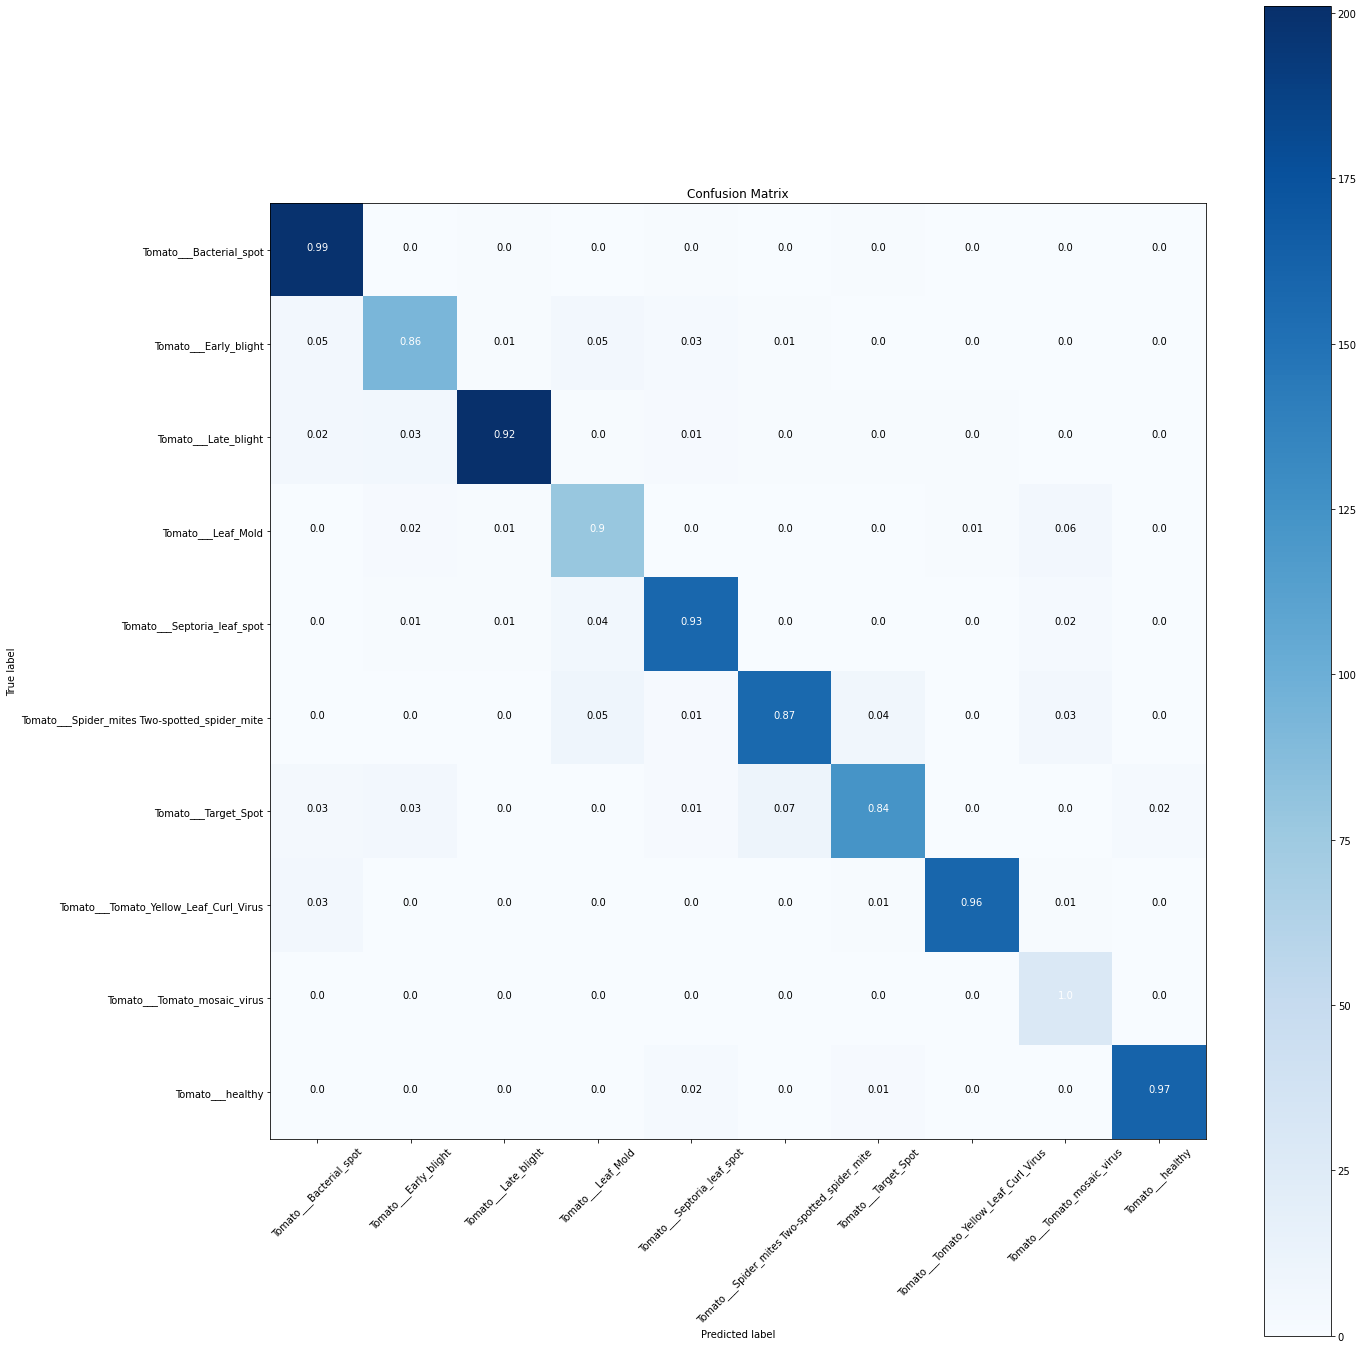

In [36]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
 

In [37]:
print('Classification Report')
print(classification_report(correct_labels,predicted_labels,target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.91      0.95       218
                        Tomato___Early_blight       0.86      0.87      0.87       107
                         Tomato___Late_blight       0.92      0.98      0.95       205
                           Tomato___Leaf_Mold       0.90      0.79      0.84        99
                  Tomato___Septoria_leaf_spot       0.93      0.92      0.93       171
Tomato___Spider_mites Two-spotted_spider_mite       0.87      0.93      0.90       169
                         Tomato___Target_Spot       0.84      0.91      0.87       135
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.96      0.99      0.97       161
                 Tomato___Tomato_mosaic_virus       1.00      0.67      0.81        43
                             Tomato___healthy       0.97      0.98      0.98       164

                   